<a href="https://colab.research.google.com/github/vincenzoaltavilla/thesis_project/blob/main/4thesis_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
seq_in = 12 #numero dei mesi passati da analizzare
seq_out = 6 #numero dei mesi futuri da predire

## **Import**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/stats_with_values.csv'

import pandas as pd
pd.set_option('display.max.rows', 500)
pd.set_option('display.max.columns', 500)

def european_format(x):
    return '{:,.2f}'.format(x).replace(',', 'X').replace('.', ',').replace('X', '.')
pd.set_option('display.float_format', european_format)

def format_market_value(value, pos):
    if value >= 1e6:
        return '{:.1f}M'.format(value * 1e-6)
    elif value >= 1e3:
        return '{:.1f}k'.format(value * 1e-3)
    else:
        return '{:.0f}'.format(value)

import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **DF**

In [ ]:
df = pd.read_csv(file_path)
"""
df = df.drop(columns=['date', 'player_name', 'country_of_citizenship', 'date_of_birth', 'club_name',
                      'club_national_league', 'position', 'sub_position', 'foot', 'height_in_cm',
                      'is_top5_league', 'club_id'])

df['is_top5_league'] = df['is_top5_league'].astype(int)

position_mapping = {'Goalkeeper': 0, 'Defense': 1, 'Midfield': 2, 'Attack': 3}
sub_position_mapping = {'Goalkeeper': 0, 'Right-Back': 1, 'Centre-Back': 2, 'Left-Back': 3,
                        'Defensive Midfield': 4, 'Right Midfield': 5, 'Central Midfield': 6,
                        'Left Midfield': 7, 'Attacking Midfield': 8, 'Right Winger': 9,
                        'Second Striker': 10, 'Left Winger': 11, 'Centre-Forward': 12}
foot_mapping = {'right': 0, 'left': 1, 'both': 2}

df['position'] = df['position'].map(position_mapping)
df['sub_position'] = df['sub_position'].map(sub_position_mapping)
df['foot'] = df['foot'].map(foot_mapping)

"""

df = df[['player_id', 'month', 'year', 'goals', 'avg_monthly_market_value_in_eur']]

#rimuovo i giocatori che non hanno abbastanza mesi per addestrare la LSTM
occurrences = df['player_id'].value_counts()
players_to_keep = occurrences[occurrences > seq_in + seq_out] .index
df = df[df['player_id'].isin(players_to_keep)].reset_index(drop=True)

print(df.shape)

In [ ]:
plt.figure(figsize=(20, 6))
plt.title(f'Valori di mercato registrati')

plt.plot(df.avg_monthly_market_value_in_eur)
plt.ylabel('Valore di mercato in €')

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_market_value))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(10000000)) #RICORDA QUESTO

plt.grid()
plt.show()

## **Separazione e standardizzazione di X e Y**

In [ ]:
X = df.drop(columns=['avg_monthly_market_value_in_eur'])
y = df.avg_monthly_market_value_in_eur.values

n_of_features = X.shape[1]
print(n_of_features)

ss = StandardScaler()
mm = MinMaxScaler()
X_trans = ss.fit_transform(X)                #media 0, deviazione standard 1
y_trans = mm.fit_transform(y.reshape(-1, 1)) #tutto tra 0 e 1

-1.1526180156589463


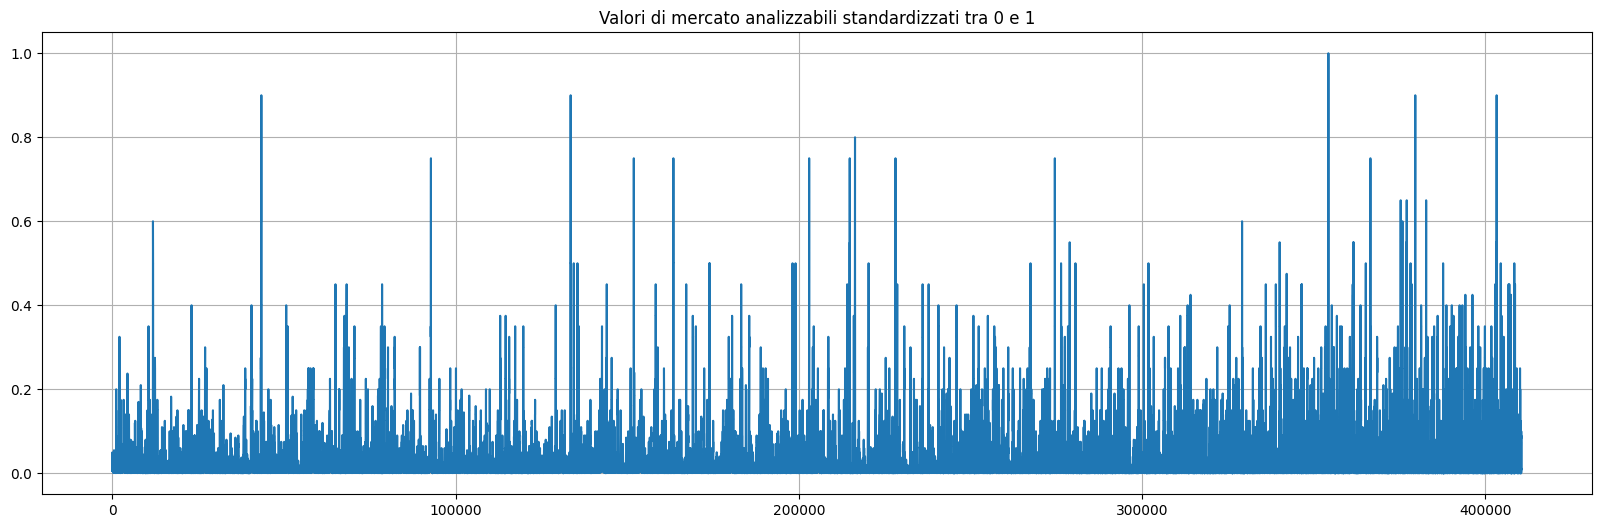

,player_id,month,year,goals,avg_monthly_market_value_in_eur
0,"-1,15","0,35","-1,77","0,91","0,03"
1,"-1,15","0,61","-1,77","3,60","0,03"
2,"-1,15","0,88","-1,77","3,60","0,03"
3,"-1,15","1,15","-1,77","2,25","0,03"
4,"-1,15","1,42","-1,77","2,25","0,03"
...,...,...,...,...,...
410417,"4,89","1,15","1,54","-0,43","0,10"
410418,"4,89","1,42","1,54","-0,43","0,08"
410419,"4,89","-1,53","1,84","0,91","0,08"
410420,"4,89","-1,26","1,84","-0,43","0,08"


In [ ]:
X_normalized = pd.DataFrame(X_trans, index=X.index, columns=X.columns)
y_normalized = pd.DataFrame(y_trans, index=X.index, columns=['avg_monthly_market_value_in_eur'])

df_normalized = pd.concat([X_normalized, y_normalized], axis=1)
print(X_trans[0][0])

plt.figure(figsize=(20, 6))
plt.title('Valori di mercato analizzabili standardizzati tra 0 e 1')
plt.plot(df_normalized.avg_monthly_market_value_in_eur)

plt.grid()
plt.show()
df_normalized

## **Creazione sequenze**

In [ ]:
def create_sequences(data_in, data_out, seq_in, seq_out):
    X = []
    y = []

    for i in range(len(data_in)):

        end_ix = i + seq_in
        end_ox = end_ix + seq_out

        if end_ox > len(data_in) : break

        if data_in[i][0] != data_in[end_ox-1][0]:
            i=end_ox
            if i > len(data_in): break
            continue

        seq_x = data_in[i:end_ix]
        seq_y = data_out[end_ix: end_ox, -1]

        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)

X_ss, y_mm = create_sequences(X_trans, y_trans, seq_in, seq_out)

4


In [ ]:
xs = pd.DataFrame(X_ss.reshape((X_ss.shape[0], X_ss.shape[1] * X_ss.shape[2])))
print(X_ss.shape)
#xs

(256130, 12, 4)


In [ ]:
xs[xs.isnull().any(axis=1)]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47


In [ ]:
ym = pd.DataFrame(y_mm)
print(ym.shape)
#ym

(256130, 6)


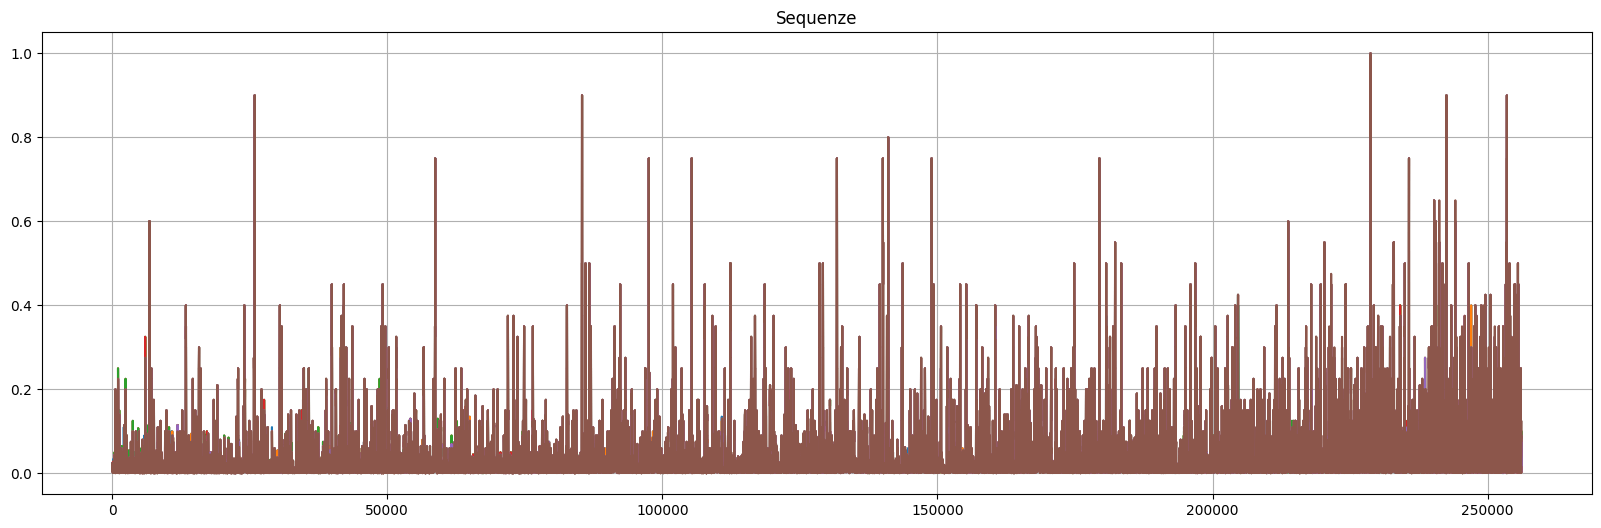

In [ ]:
plt.figure(figsize=(20, 6))
plt.title('Sequenze')
plt.plot(y_mm[seq_in:])
plt.grid()
plt.show()

## **Split in training set e test set**

In [ ]:
#80% circa training 20% circa test, si va alla posizione intorno a 80%, si scorre indietro fino a
#trovare la sequenza relativa ad un altro giocatore, lì si fa lo split
total_samples = len(X_ss)
train_test_cutoff = round(0.8 * total_samples)

i = 1
while X_ss[train_test_cutoff-i][0][0] == X_ss[train_test_cutoff][0][0]:
    i+=1
train_test_cutoff = train_test_cutoff-i

total_tests = total_samples - train_test_cutoff
print(train_test_cutoff, "+", total_tests, "=", total_samples, "=", train_test_cutoff + total_tests)

X_train = X_ss[:-total_tests]
X_test = X_ss[-total_tests:]
y_train = y_mm[:-total_tests]
y_test = y_mm[-total_tests:]

204892 + 51238 = 256130 = 256130


## **RIMOZIONE PLAYER_ID?**

In [ ]:
pd.DataFrame(X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2])))

## **Conversioni finali**

In [ ]:
#Conversione a tensori pytorch
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))
y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

# impostando input per LSTM
X_train_tensors_final = torch.reshape(X_train_tensors,
                                      (X_train_tensors.shape[0],    #Totale righe di training
                                       seq_in,                      #Totale sequenze per riga
                                       X_train_tensors.shape[2]))   #Features per ogni sequenza

X_test_tensors_final = torch.reshape(X_test_tensors,
                                     (X_test_tensors.shape[0],      #Totale righe di test
                                      seq_in,                       #Totale sequenze per riga
                                      X_test_tensors.shape[2]))     #Features per ogni sequenza

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape: torch.Size([204892, 12, 4]) torch.Size([204892, 6])
Testing Shape: torch.Size([51238, 12, 4]) torch.Size([51238, 6])


## **LSTM**

In [ ]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size1, hidden_size2):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2

        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size1, batch_first=True)
        self.dropout1 = nn.Dropout(0.5)
        self.lstm2 = nn.LSTM(input_size=hidden_size1, hidden_size=hidden_size2, batch_first=True)
        self.dropout2 = nn.Dropout(0.5)

        self.fc = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        h0_1 = Variable(torch.zeros(1, x.size(0), self.hidden_size1))
        c0_1 = Variable(torch.zeros(1, x.size(0), self.hidden_size1))
        h0_2 = Variable(torch.zeros(1, x.size(0), self.hidden_size2))
        c0_2 = Variable(torch.zeros(1, x.size(0), self.hidden_size2))

        out, _ = self.lstm1(x, (h0_1, c0_1))
        out = self.dropout1(out)
        out, _ = self.lstm2(out, (h0_2, c0_2))
        out = self.dropout2(out)

        out = out[:, -1, :]
        out = self.fc(out)
        return out

def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train, X_test, y_test, batch_size):
    for epoch in tqdm(range(n_epochs), desc="Training Progress"):

        lstm.train()
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            outputs = lstm(X_batch)
            optimiser.zero_grad()
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimiser.step()

        lstm.eval()
        with torch.no_grad():
            test_preds = lstm(X_test)
            test_loss = loss_fn(test_preds, y_test)

        if epoch % 10 == 0:
            print(f'\nEpoch: {epoch}, train loss: {loss.item():.5f}, test loss: {test_loss.item():.5f}')

## **Addestramento**

In [ ]:
# Parametri
n_epochs = 100
learning_rate = 0.001
input_size = n_of_features
hidden_size1 = 64
hidden_size2 = 32
num_classes = seq_out
batch_size = 64

lstm = LSTM(num_classes, input_size, hidden_size1, hidden_size2)
loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors,
              batch_size=batch_size)

lstm.eval()
with torch.no_grad():
    y_pred = lstm(X_test_tensors_final)

y_pred_np = y_pred.detach().numpy()
y_test_np = y_test_tensors.detach().numpy()

print("Mean Squared Error:", mean_squared_error(y_test_np, y_pred_np))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test_np, y_pred_np)))
print("R^2 Score:", r2_score(y_test_np, y_pred_np))

Training Progress:   1%|          | 1/100 [00:49<1:21:47, 49.57s/it]

 Epoch: 0, train loss: 0.00075, test loss: 0.00704, ETA: 81.78 minutes


Training Progress:  11%|█         | 11/100 [08:37<1:09:00, 46.52s/it]

 Epoch: 10, train loss: 0.00132, test loss: 0.01173, ETA: 68.58 minutes


Training Progress:  21%|██        | 21/100 [16:04<59:00, 44.82s/it]

 Epoch: 20, train loss: 0.00162, test loss: 0.00627, ETA: 58.88 minutes


Training Progress:  31%|███       | 31/100 [23:37<52:18, 45.48s/it]

 Epoch: 30, train loss: 0.00170, test loss: 0.00623, ETA: 52.82 minutes


Training Progress:  41%|████      | 41/100 [31:07<44:10, 44.93s/it]

 Epoch: 40, train loss: 0.00180, test loss: 0.00652, ETA: 43.79 minutes


Training Progress:  51%|█████     | 51/100 [38:40<37:18, 45.68s/it]

 Epoch: 50, train loss: 0.00112, test loss: 0.00633, ETA: 37.99 minutes


Training Progress:  61%|██████    | 61/100 [46:36<31:09, 47.95s/it]

 Epoch: 60, train loss: 0.00137, test loss: 0.00701, ETA: 30.32 minutes


Training Progress:  71%|███████   | 71/100 [55:57<24:36, 50.90s/it]

 Epoch: 70, train loss: 0.00173, test loss: 0.00824, ETA: 22.21 minutes


Training Progress:  81%|████████  | 81/100 [1:03:37<14:38, 46.21s/it]

 Epoch: 80, train loss: 0.00133, test loss: 0.00856, ETA: 14.52 minutes


Training Progress:  91%|█████████ | 91/100 [1:11:10<06:47, 45.31s/it]

 Epoch: 90, train loss: 0.00128, test loss: 0.01020, ETA: 6.77 minutes


Training Progress: 100%|██████████| 100/100 [1:18:00<00:00, 46.80s/it]


## **Test**

In [ ]:
"""
dates = stats.iloc[n_samples-1:].index

plt.figure(figsize=(20, 6))
plt.title(f'Predizione del valore di mercato di {name}')
plt.plot(dates, true, label='Valore reale')
plt.plot(dates, preds, label='Valore predetto')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()
"""
df_X_ss = ss.transform(df.drop(columns=['avg_monthly_market_value_in_eur']))
df_y_mm = mm.transform(df.avg_monthly_market_value_in_eur.values.reshape(-1, 1))

df_X_ss, df_y_mm = create_sequences(df_X_ss, df_y_mm, seq_in, seq_out)
df_X_ss = Variable(torch.Tensor(df_X_ss))
df_y_mm = Variable(torch.Tensor(df_y_mm))

df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], seq_in, df_X_ss.shape[2]))

train_predict = lstm(df_X_ss)
data_predict = train_predict.data.numpy()
data_predict = mm.inverse_transform(data_predict)

dataY_plot = df_y_mm.data.numpy()
dataY_plot = mm.inverse_transform(dataY_plot)

## **Risultati**

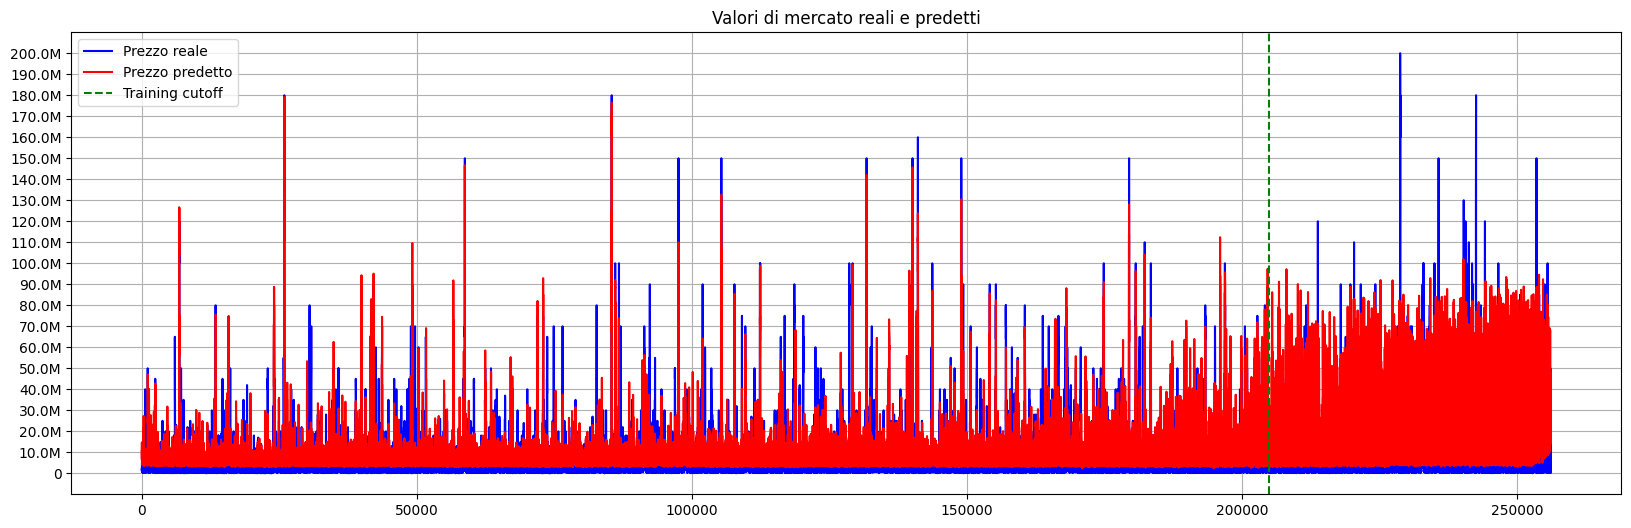

In [ ]:
true, preds = [], []

for i in range(len(dataY_plot)):
    if i == len(dataY_plot) - 1:
        for j in range(seq_out):
            true.append(dataY_plot[i][j])
    else:
        true.append(dataY_plot[i][0])

for i in range(len(data_predict)):
    if i == len(data_predict) - 1:
        for j in range(seq_out):
            preds.append(data_predict[i][j])
    else:
        preds.append(data_predict[i][0])

plt.figure(figsize=(20, 6))
plt.title('Valori di mercato reali e predetti')
plt.plot(true, color='blue', label='Prezzo reale')
plt.plot(preds, color='red', label='Prezzo predetto')

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_market_value))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(10000000)) #RICORDA QUESTO
plt.axvline(x=train_test_cutoff, c='green', linestyle='--', label='Training cutoff')

plt.grid()
plt.legend()
plt.show()

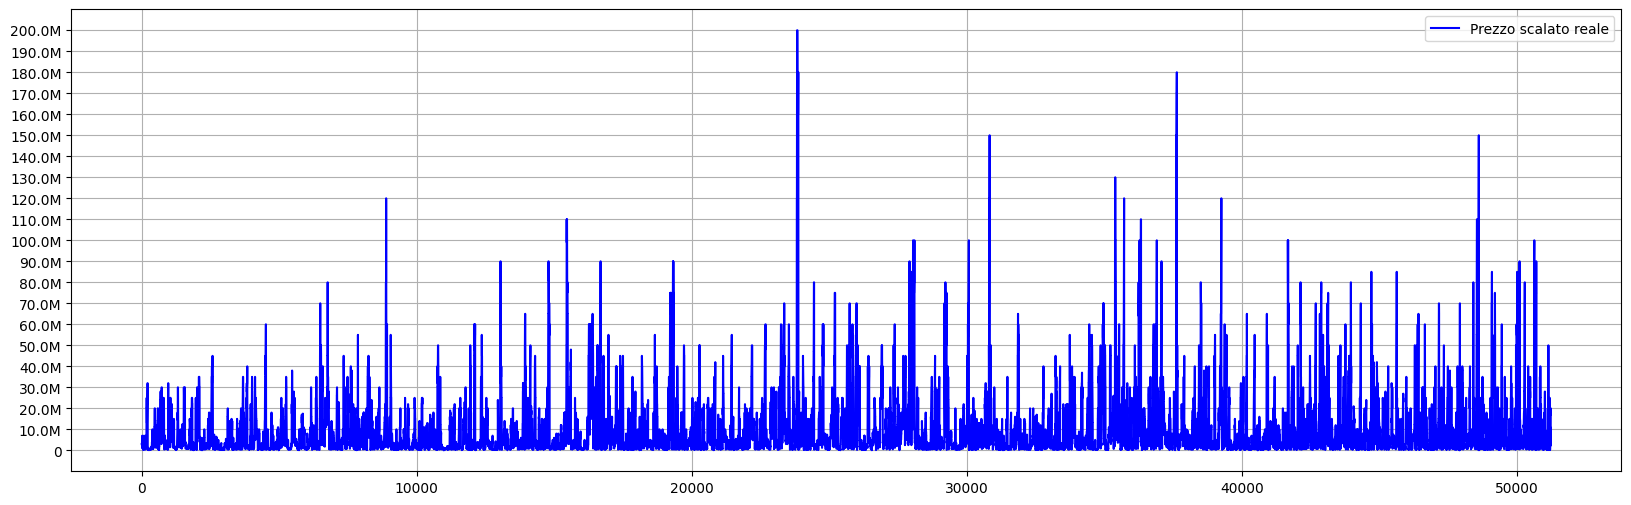

In [ ]:
true = []

for i in range(len(dataY_plot)):
    if i == len(dataY_plot) - 1:
        for j in range(seq_out):
            true.append(dataY_plot[i][j])
    else:
        true.append(dataY_plot[i][0])

plt.figure(figsize=(20, 6))
plt.plot(true[train_test_cutoff:], color='blue', label='Prezzo scalato reale')

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_market_value))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(10000000)) #RICORDA QUESTO
plt.legend()
plt.grid()
plt.show()

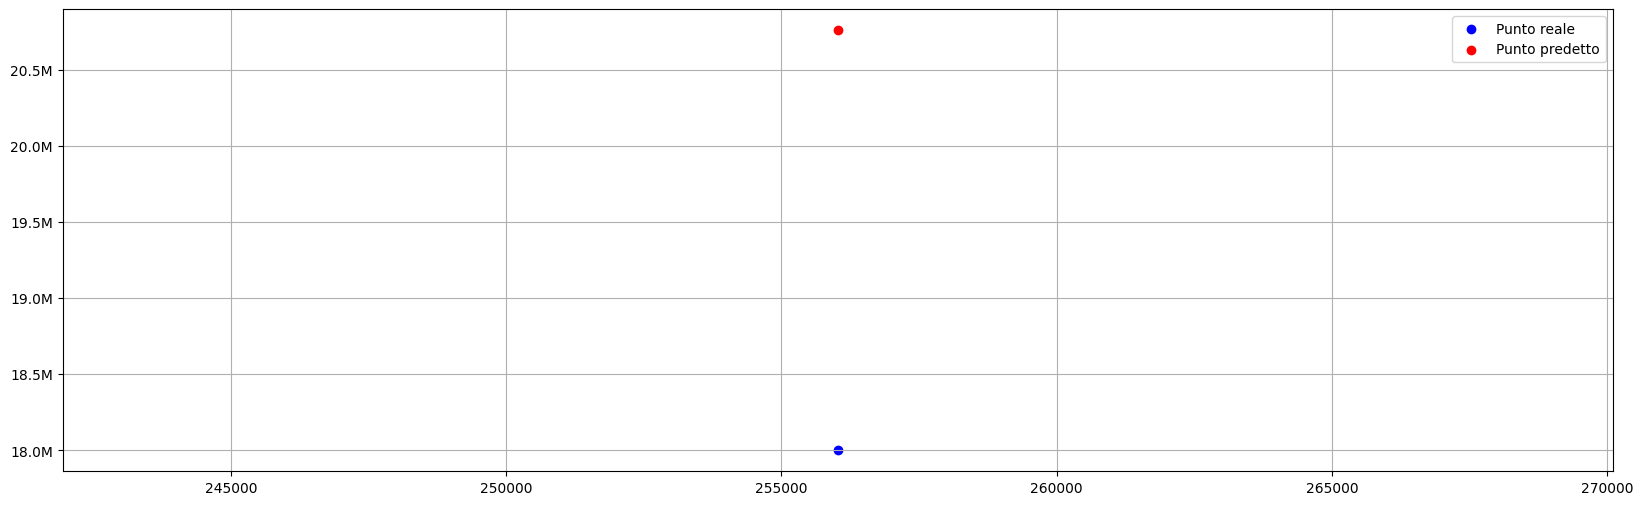

In [ ]:
preds = []

for i in range(len(data_predict)):
    if i == len(data_predict) - 1:
        for j in range(seq_out):
            preds.append(data_predict[i][j])
    else:
        preds.append(data_predict[i][0])

index = 256020
val2 = preds[index]
val1 = true[index]

plt.figure(figsize=(20, 6))
plt.scatter(index, val1, color='blue', label='Punto reale')
plt.scatter(index, val2, color='red', label='Punto predetto')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_market_value))
plt.grid()
plt.legend()
plt.show()

In [ ]:
x2 = pd.DataFrame(preds, columns=['Predicted Prices'])
x3 = pd.DataFrame(true, columns=['Real Prices'])
combined_df = pd.concat([x3, x2], axis=1)
combined_df['a'] = combined_df.index

tolerance = 0.20
within_tolerance = combined_df.apply(lambda row: abs(row['Predicted Prices'] - row['Real Prices']) / row['Real Prices'] <= tolerance, axis=1)

In [ ]:
x = combined_df[within_tolerance]
x[x['a'] > train_test_cutoff]

,Real Prices,Predicted Prices,a
204922,"5.000.000,00","5.976.523,00",204922
204924,"5.000.000,00","5.015.440,00",204924
204925,"5.000.000,00","4.747.962,50",204925
204926,"5.000.000,00","4.186.756,75",204926
204929,"4.500.000,00","4.778.409,00",204929
...,...,...,...
256019,"18.000.000,00","16.437.586,00",256019
256020,"18.000.000,00","20.762.922,00",256020
256043,"50.000.000,00","48.095.284,00",256043
256089,"20.000.002,00","23.776.174,00",256089
